## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

# Standard libraries
from pathlib import Path
import pprint

# Third-party libraries
import duckdb
import fireducks.pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import rcParams
from matplotlib.lines import Line2D

rcParams["text.usetex"] = True

# Custom osbad library for anomaly detection
import osbad.config as bconf
import osbad.modval as modval
import osbad.viz as bviz
from osbad.database import BenchDB
from osbad.model import ModelRunner

# importing distance based anomaly detection utilities
from osbad import dbad

## Import Dataset

### Define Filepath

In [2]:
# Define a global variable to save fig output
# The definition of PIPELINE_OUTPUT_DIR can be
# found in config.py
PIPELINE_OUTPUT_DIR = bconf.PIPELINE_OUTPUT_DIR

In [3]:
# Load only the training dataset
db_filepath = str(
    Path.cwd()
    .parent
    .joinpath("database","train_dataset_severson.db"))

### Get cell inventory of training dataset

In [4]:
# Create a DuckDB connection
con = duckdb.connect(
    db_filepath,
    read_only=True)

# Load all training dataset from duckdb
df_duckdb = con.execute(
    "SELECT * FROM df_train_dataset_sv").fetchdf()

unique_cell_index_train = df_duckdb["cell_index"].unique()
print(unique_cell_index_train)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

['2017-05-12_5_4C-50per_3C_CH13' '2017-05-12_5_4C-50per_3C_CH14'
 '2017-05-12_5_4C-60per_3C_CH15' '2017-05-12_5_4C-60per_3C_CH16'
 '2017-05-12_5_4C-70per_3C_CH17' '2017-05-12_5_4C-70per_3C_CH18'
 '2017-05-12_6C-40per_3C_CH25' '2017-05-12_6C-40per_3C_CH26'
 '2017-05-12_6C-50per_3C_CH27' '2017-05-12_6C-50per_3C_CH28'
 '2017-05-12_6C-60per_3C_CH29' '2017-05-12_6C-60per_3C_CH30'
 '2017-05-12_7C-40per_3C_CH37' '2017-05-12_7C-40per_3C_CH38'
 '2017-05-12_4C-80per_4C_CH5' '2017-05-12_4C-80per_4C_CH6'
 '2017-05-12_4_4C-80per_4_4C_CH7' '2017-05-12_5_4C-80per_5_4C_CH11'
 '2017-05-12_5_4C-80per_5_4C_CH12' '2017-05-12_3_6C-80per_3_6C_CH1'
 '2017-05-12_3_6C-80per_3_6C_CH2' '2017-05-12_3_6C-80per_3_6C_CH3'
 '2017-05-12_5_4C-40per_3_6C_CH19']


In [5]:
training_cell_count = len(unique_cell_index_train)
print(f"Training cell count: {training_cell_count}")

Training cell count: 23


### Select a cell label

In [6]:
# Get the cell-ID from cell_inventory
selected_cell_label = "2017-05-12_5_4C-70per_3C_CH17"

# Create a subfolder to store fig output 
# corresponding to each cell-index
selected_cell_artifacts =  PIPELINE_OUTPUT_DIR.joinpath(
    selected_cell_label)

### Load benchmarking dataset and drop labels

In [7]:
# Import the BenchDB class
# Load only the dataset based on the selected cell
benchdb = BenchDB(
    db_filepath,
    selected_cell_label)

# load the benchmarking dataset
df_selected_cell = benchdb.load_benchmark_dataset(
    dataset_type="train")

if df_selected_cell is not None:

    filter_col = [
        "cell_index",
        "cycle_index",
        "discharge_capacity",
        "voltage"]

    # Drop true labels from the benchmarking dataset
    # and filter for selected columns only
    df_selected_cell_without_labels = benchdb.drop_labels(
        df_selected_cell,
        filter_col)
    
    # print a subset of the dataframe
    # for diagnostics running in terminals
    print(df_selected_cell_without_labels.head(10).to_markdown())
    print("*"*100)

Database is found in the given filepath.
Loading benchmarking dataset now...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

****************************************************************************************************
|    | cell_index                    |   cycle_index |   discharge_capacity |   voltage |
|---:|:------------------------------|--------------:|---------------------:|----------:|
|  0 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          1.26512e-05 |   3.29189 |
|  1 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00136774  |   3.28185 |
|  2 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00292998  |   3.27788 |
|  3 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  4 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00449361  |   3.27513 |
|  5 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00605927  |   3.27299 |
|  6 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.00762155  |   3.27124 |
|  7 | 2017-05-12_5_4C-70per_3C_CH17 |             0 |          0.0091859   |   3.2703  |

### Plot cycle data without labels

<Axes: title={'center': 'Cell 2017-05-12_5_4C-70per_3C_CH17'}, xlabel='Discharge capacity, $Q_\\textrm{dis}$ [Ah]', ylabel='Discharge voltage, $V_\\textrm{dis}$ [V]'>

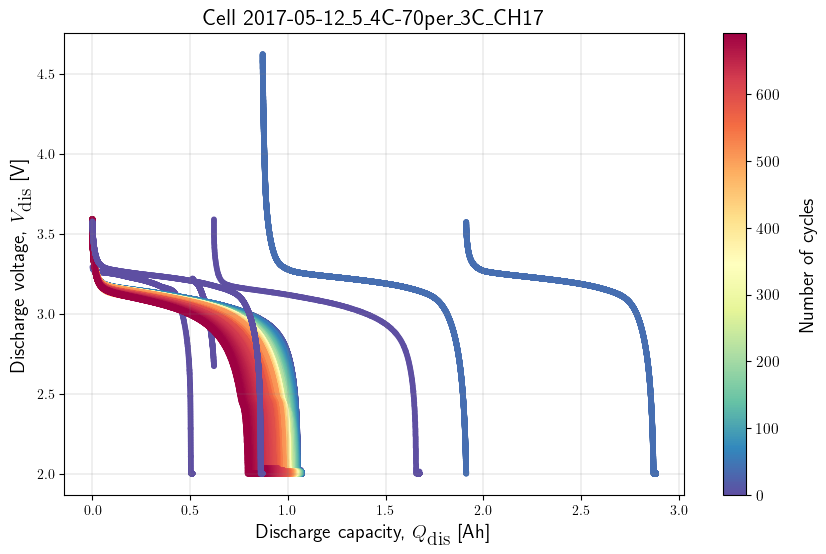

In [8]:
# If the true outlier cycle index is not known,
# cycling data will be plotted without labels
benchdb.plot_cycle_data(
    df_selected_cell_without_labels)

plt.show()

## Features transformation

### Load the training features dataset

In [9]:
# Define the filepath to ``train_features_severson.db``
# DuckDB instance.
db_features_filepath = (
    Path.cwd()
    .parent
    .joinpath("database","train_features_severson.db"))

# Load only the training features dataset
df_features_per_cell = benchdb.load_features_db(
    db_features_filepath,
    dataset_type="train")
print(df_features_per_cell.head(10).to_markdown())
print("*"*100)

unique_cycle_count = (
    df_features_per_cell["cycle_index"].unique())

Features database is found in the given filepath.
Features database is loaded.
****************************************************************************************************
|    |   max_diff_dQ |   log_max_diff_dQ |   cycle_index |   max_diff_dV |   log_max_diff_dV | cell_index                    |
|---:|--------------:|------------------:|--------------:|--------------:|------------------:|:------------------------------|
|  0 |    0.00638794 |          -5.05334 |             0 |     1.56415   |          0.447343 | 2017-05-12_5_4C-70per_3C_CH17 |
|  1 |    0.00633758 |          -5.06126 |             1 |     0.0237265 |         -3.74116  | 2017-05-12_5_4C-70per_3C_CH17 |
|  2 |    0.00632072 |          -5.06392 |             2 |     0.0226841 |         -3.78609  | 2017-05-12_5_4C-70per_3C_CH17 |
|  3 |    0.00625887 |          -5.07376 |             3 |     0.0278988 |         -3.57917  | 2017-05-12_5_4C-70per_3C_CH17 |
|  4 |    0.00623644 |          -5.07735 |             4 |

# Distance from Centroid

In [10]:
selected_feature_cols = (
    #"cycle_index",
    "log_max_diff_dQ",
    "log_max_diff_dV")

runner = ModelRunner(
        cell_label=selected_cell_label,
        df_input_features=df_features_per_cell,
        selected_feature_cols=selected_feature_cols)

features = runner.create_model_x_input()
#features = Xdata[:,1:]
#cycle_idx = Xdata[:,0]
centroid = np.median(features, axis=0)

### Euclidean Distance

In [11]:
metric_name= "euclidean"

euclidean_dist, max_euclidean_dist = dbad.calculate_distance(
    metric_name=metric_name,
    features=features,
    centroid=centroid,
    norm=True)

(pred_outlier_indices, 
 pred_outlier_distance, 
 pred_outlier_features,
 euclidean_threshold) = dbad.predict_outliers(
                            distance=euclidean_dist,
                            features= features,
                            mad_threshold=3)

print("\nPredicted Anomalous Cycles:", pred_outlier_indices)
print("Euclidean distance for Outlier Cycles:", pred_outlier_distance)
print("Euclidean Threshold:", euclidean_threshold)

Feature median: 0.023977594551892294
Feature z-score mean: 0.0
Feature z-score std. deviation: 1.0
MAD: 0.08951898753216427
MAD min limit: -0.2445793680446005
MAD max limit: 0.2925345571483851

Predicted Anomalous Cycles: [  0  40 147 148]
Euclidean distance for Outlier Cycles: [0.88129539 1.         0.44559177 0.45050396]
Euclidean Threshold: 0.2925345571483851


### Plot histogram of distances

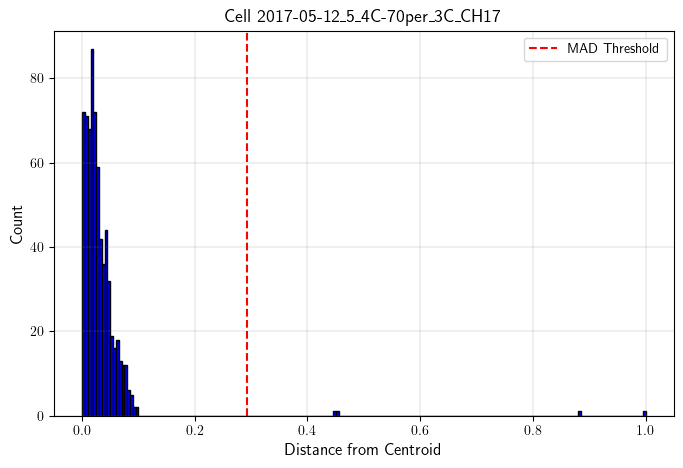

In [12]:
axplot = dbad.plot_hist_distance(distance=euclidean_dist, 
                              #outlier_indices=pred_outlier_indices,
                              threshold=euclidean_threshold)

axplot.set_title(f"Cell {selected_cell_label}", fontsize=13)

filename=f"{metric_name}_histogram"
output_fig_filename = (
    filename + "_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts.joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()

## Get df_outliers_pred

In [13]:
df_outliers_pred = df_features_per_cell[
    df_features_per_cell["cycle_index"].isin(pred_outlier_indices)].copy()

df_outliers_pred["outlier_distance"] = pred_outlier_distance

df_outliers_pred

,max_diff_dQ,log_max_diff_dQ,cycle_index,max_diff_dV,log_max_diff_dV,cell_index,outlier_distance
0,0.006388,-5.053343,0.0,1.564151,0.447343,2017-05-12_5_4C-70per_3C_CH17,0.881295
40,0.006305,-5.066425,40.0,2.612268,0.960219,2017-05-12_5_4C-70per_3C_CH17,1.000000
147,0.042814,-3.150895,147.0,0.029431,-3.525697,2017-05-12_5_4C-70per_3C_CH17,0.445592
148,0.042899,-3.148905,148.0,0.025238,-3.679404,2017-05-12_5_4C-70per_3C_CH17,0.450504


## Plot distance score mapping

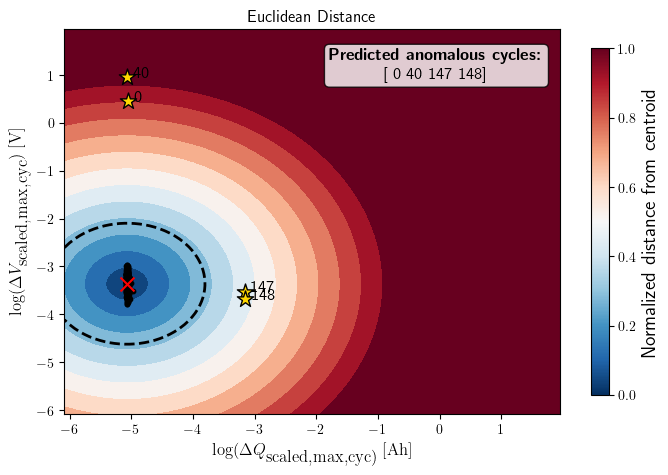

In [14]:
xx, yy, meshgrid = runner.create_2d_mesh_grid()

grid_euclidean_dist = dbad.calculate_distance(
        metric_name=metric_name,
        features=meshgrid,
        centroid=centroid,
        max_distance = max_euclidean_dist,
        norm=True)
                
axplot= dbad.plot_distance_score_map(
        meshgrid_distance = grid_euclidean_dist,
        xx = xx,
        yy = yy,
        features=features,
        xoutliers= df_outliers_pred["log_max_diff_dQ"],
        youtliers= df_outliers_pred["log_max_diff_dV"],
        centroid=centroid,
        threshold= euclidean_threshold,
        pred_outlier_indices= pred_outlier_indices,
        norm=True
        #max_outlier_dist=max(pred_outlier_distance)
        )

axplot.set_title('Euclidean Distance', fontsize=12)

filename = f"{metric_name}_dist_map"

output_fig_filename = (
        filename + "_"
        + selected_cell_label
        + ".png")

fig_output_path = (selected_cell_artifacts.
                   joinpath(output_fig_filename))

plt.savefig(
        fig_output_path,
        dpi=600,
        bbox_inches="tight")

plt.show()

## Method Performance Evaluation

In [15]:
df_eval_outlier = modval.evaluate_pred_outliers(
    df_benchmark=df_selected_cell,
    outlier_cycle_index=pred_outlier_indices)

### Confusion Matrix

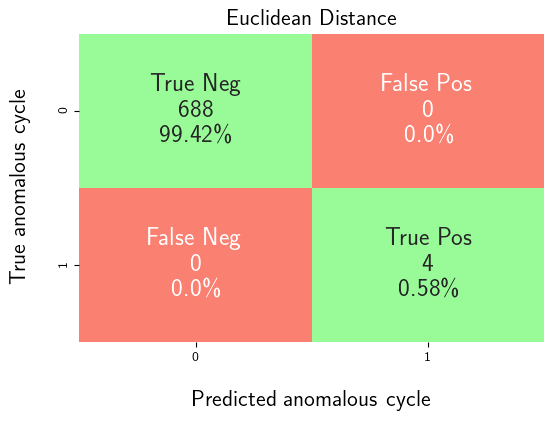

In [16]:
axplot = modval.generate_confusion_matrix(
    y_true=df_eval_outlier["true_outlier"],
    y_pred=df_eval_outlier["pred_outlier"])

axplot.set_title(
    "Euclidean Distance",
    fontsize=16)

output_fig_filename = (
    "conf_matrix_euclidean_"
    + selected_cell_label
    + ".png")

fig_output_path = (
    selected_cell_artifacts
    .joinpath(output_fig_filename))

plt.savefig(
    fig_output_path,
    dpi=600,
    bbox_inches="tight")

plt.show()